In [54]:
import os
from mpasanalysis import *
%matplotlib inline

[268.09664381 500.83089206 681.97038925 366.61692292  95.52996967
  26.03920505  18.12996002  19.79677653  35.10198674  51.69936096
  75.85063992 124.24523664]


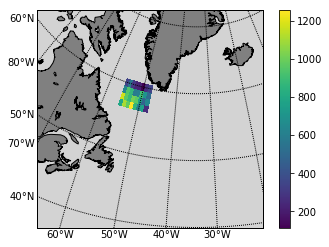

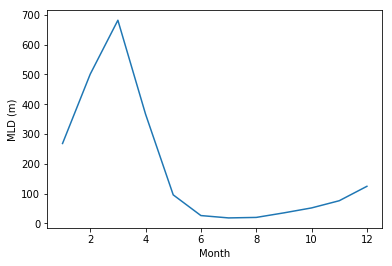

In [55]:
# Obs from Holte et al. 2017

# load data
obs_root = os.environ['HOME']+'/data/obs'
path_mld_obs = obs_root+'/MLD/mld_1.0x1.0degree.nc'
data_mld = Dataset(path_mld_obs, 'r')
Dataset.set_auto_mask(data_mld, False)
lat_obs = data_mld.variables['lat'][:]
lon_obs = data_mld.variables['lon'][:]
mld_obs = data_mld.variables['mld'][:]

# process data and create region mask
lon_obs[lon_obs<0] = lon_obs[lon_obs<0]+360
lon2d, lat2d = np.meshgrid(lon_obs, lat_obs)
mld_obs[mld_obs>5000.]=np.nan
robj = region_latlon('LabSea_SD1')
mask = (lon2d>robj.lon_ll) & (lon2d<robj.lon_ur) & (lat2d>robj.lat_ll) & (lat2d<robj.lat_ur)
mld_masked = np.ma.array(mld_obs[:,:,2], mask=~mask)

# plot the region
plt.figure()
region_obj = region_latlon('LabSea')
lon_ll, lat_ll, lon_ur, lat_ur = region_obj.lon_ll, region_obj.lat_ll, region_obj.lon_ur, region_obj.lat_ur
lon_c = 0.5*(lon_ll+lon_ur)
lat_c = 0.5*(lat_ll+lat_ur)
m = Basemap(projection='cass', llcrnrlon=lon_ll, llcrnrlat=lat_ll,
            urcrnrlon=lon_ur, urcrnrlat=lat_ur, resolution='l', lon_0=lon_c, lat_0=lat_c )
m.drawcoastlines()
m.drawmapboundary(fill_color='lightgray')
m.fillcontinents(color='gray',lake_color='lightgray')
m.drawparallels(np.arange(-90.,91.,10), labels=[1,0,0,1])
m.drawmeridians(np.arange(0.,361.,10), labels=[1,0,0,1])
x, y = m(lon2d, lat2d)
m.pcolor(x, y, mld_masked)
plt.colorbar()

# compute regional averaged MLD
cellarea = np.cos(np.deg2rad(lat2d))
mld_obs_rm = np.zeros(12)
for i in np.arange(12):
    tmp = mld_obs[:,:,i]
    mask[np.isnan(tmp)] = False
    mld_masked = np.ma.array(mld_obs[:,:,i], mask=~mask)
    mld_obs_rm[i] = np.ma.average(mld_masked, weights=cellarea)
    
# plot mean MLD
plt.figure()
plt.plot(np.arange(12)+1, mld_obs_rm)
plt.xlabel('Month')
plt.ylabel('MLD (m)')

# save data
print(mld_obs_rm)
path_obs = obs_root+'/MLD/data_ts_LabSea_SD1_avg_MLD_Argo.npz'
np.savez(path_obs, mld=mld_obs_rm)